# Preprocesing Dataset

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn

## Libraries used

In [2]:
print("Required libraries installed successfully.")

Required libraries installed successfully.


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

#GPU configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
UNUSED_COLS = [
    "Unnamed: 0", "Flow Bytes/s", "Flow Packets/s", "Class"
]

# 1. LOAD
def load_dataset(path):
    return pd.read_csv(path)

# 2. CLEANING
def clean_dataset(df):
    for col in UNUSED_COLS:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    return df

# 3. SPLIT BEFORE SCALING & WINDOWING
def split_train_test(df, test_size=0.2):
    train_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)
    return train_df, test_df

# 4. LABEL ENCODING (fit on entire dataset so all classes exist)
def encode_labels_full(df, train_df, test_df):
    le = LabelEncoder()
    le.fit(df["DDoS"])                    # Fit on total label vocabulary

    train_df["DDoS"] = le.transform(train_df["DDoS"])
    test_df["DDoS"] = le.transform(test_df["DDoS"])
    return train_df, test_df, le

# 5. SCALING (fit on train only!)
def scale_train_test(train_df, test_df):
    scaler = StandardScaler()
    feature_cols = train_df.columns[train_df.columns != "DDoS"]

    # Fit on training features only
    train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

    # Transform test using train params
    test_df[feature_cols] = scaler.transform(test_df[feature_cols])

    return train_df, test_df, scaler

# 6. SEQUENCE GENERATION
def create_sequences(df, window=30):
    features = df.drop(columns=["DDoS"]).values
    labels = df["DDoS"].values

    X, y = [], []
    for i in range(len(df) - window):
        X.append(features[i:i+window])
        y.append(labels[i+window])

    return np.array(X), np.array(y)


In [5]:
class RNNModel(nn.Module):
    def __init__(self, num_features, num_classes, hidden_size=128, num_layers=2):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]      # Last timestep
        return self.fc(out)
    
class TransformerTimeSeries(nn.Module):
    def __init__(self, num_features, num_classes, dim=128, num_heads=4, num_layers=2):
        super().__init__()

        # Linear embedding from feature dimension → transformer dimension
        self.embedding = nn.Linear(num_features, dim)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=num_heads,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )

        # Final classifier
        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, num_features)
        x = self.embedding(x)          # (batch, seq_len, dim)
        x = self.transformer(x)        # (batch, seq_len, dim)

        # --- FIX: Use mean-pooling instead of last timestep ---
        x = x.mean(dim=1)              # (batch, dim)

        return self.fc(x)              # (batch, num_classes)
    
def compute_metrics(y_true, y_pred):
    acc = (y_true == y_pred).float().mean().item()
    f1 = 0  # you can add sklearn F1 here if desired
    return acc, f1

## Auxiliar

In [6]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001):
        """
        patience: how many epochs to wait without improvement
        min_delta: minimum improvement required to reset patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def step(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.should_stop = True


## Training

In [9]:
PATH = r"C:\Users\Ale\Downloads\Final_IA\final_dataset.csv"
BATCH = 64
EPOCHS = 10
WINDOW = 10

df = load_dataset(PATH)
df = clean_dataset(df)

# 1. Split BEFORE encoding & scaling
train_df, test_df = split_train_test(df)

# 2. Encode labels on full vocabulary but applied separately
train_df, test_df, label_encoder = encode_labels_full(df, train_df, test_df)

# 3. Scale using only training stats
train_df, test_df, scaler = scale_train_test(train_df, test_df)

# 4. Create windows for train/test
X_train, y_train = create_sequences(train_df, window=WINDOW)
X_test,  y_test  = create_sequences(test_df,  window=WINDOW)

pred_x = X_test[-2:] 
pred_y = y_test[-2:]
X_test = X_test[:-2]    
y_test = y_test[:-2] 


# 5. Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


# RNN

In [10]:
# --- DEVICE (CRITICAL FIX: GPU or CPU automatically) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 7. Define model (MOVE TO GPU)
num_features = X_train.shape[2]
num_classes = len(label_encoder.classes_)

model = RNNModel(num_features, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# --- NEW: VALIDATION SPLIT (NEEDED!) ---
# Use last 10% of training windows as validation
val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=BATCH,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=BATCH,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


# 6. Create DataLoaders with workers (CRITICAL SPEED FIX)

# 8. TRUE EARLY STOPPING ON VALIDATION LOSS
early_stopper = EarlyStopping(patience=3, min_delta=0.001)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- VALIDATION ----------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

    early_stopper.step(avg_val_loss)
    if early_stopper.should_stop:
        print("\n⛔ Early stopping triggered — training stopped.")
        break


Using device: cuda
Epoch 1 | Train Loss = 0.2333 | Val Loss = 0.0003
Epoch 2 | Train Loss = 0.2018 | Val Loss = 0.0002
Epoch 3 | Train Loss = 0.1978 | Val Loss = 0.0001
Epoch 4 | Train Loss = 0.1961 | Val Loss = 0.0001

⛔ Early stopping triggered — training stopped.


In [11]:
model.eval()
all_preds = []
all_true = []

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=BATCH,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

with torch.no_grad():
    for xb, yb in test_loader:
        # GPU transfers
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # Forward pass
        preds = model(xb)

        # Convert logits → class indices
        preds = torch.argmax(preds, dim=1)

        # Move to CPU to accumulate metrics
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(yb.cpu().numpy())

# ----- METRICS -----
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(all_true, all_preds))
print("F1-score (weighted):", f1_score(all_true, all_preds, average="weighted"))
print("\nClassification report:\n")
print(classification_report(all_true, all_preds, digits=4))


Accuracy: 0.9998492980768117
F1-score (weighted): 0.9998492679567348

Classification report:

              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999     72959
           1     1.0000    0.9990    0.9995     13304

    accuracy                         0.9998     86263
   macro avg     0.9999    0.9995    0.9997     86263
weighted avg     0.9998    0.9998    0.9998     86263



### **Confusion matrix**


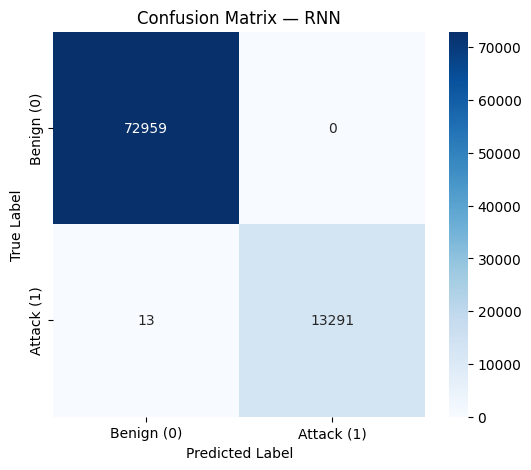

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# ===== Confusion Matrix =====
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign (0)", "Attack (1)"],
            yticklabels=["Benign (0)", "Attack (1)"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — RNN")
plt.show()


### *Prediction*

RNNModel(
  (rnn): LSTM(38, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
X_1 = pred_x[0] 
X_2 = pred_x[1]   

y_1 = pred_y[0]
y_2 = pred_y[1]


In [23]:
# 1. Detect device
device = next(model.parameters()).device

# 2. Prepare inputs
X_1 = torch.tensor(pred_x[0], dtype=torch.float32).unsqueeze(0).to(device)
X_2 = torch.tensor(pred_x[1], dtype=torch.float32).unsqueeze(0).to(device)

y_1 = torch.tensor(pred_y[0], dtype=torch.long).to(device)
y_2 = torch.tensor(pred_y[1], dtype=torch.long).to(device)


In [31]:
import time

model.eval()

# ---- Prediction for sample 1 ----
start_1 = time.perf_counter()

with torch.no_grad():
    out_1 = model(X_1)

end_1 = time.perf_counter()

pred_1 = torch.argmax(out_1, dim=1).item()
time_1 = (end_1 - start_1) * 1000   # to milliseconds

print(f"Sample 1 → Pred: {pred_1} | True: {y_1.item()} | Time: {time_1:.4f} ms")


# ---- Prediction for sample 2 ----
start_2 = time.perf_counter()

with torch.no_grad():
    out_2 = model(X_2)

end_2 = time.perf_counter()

pred_2 = torch.argmax(out_2, dim=1).item()
time_2 = (end_2 - start_2) * 1000   # to milliseconds

print("\nRNN predictions:")
print(f"Sample 2 → Pred: {pred_2} | True: {y_2.item()} | Time: {time_2:.4f} ms")


Sample 1 → Pred: 1 | True: 1 | Time: 1.9625 ms

RNN predictions:
Sample 2 → Pred: 1 | True: 1 | Time: 1.2100 ms


# **Transformers**


In [10]:
print("num_classes =", num_classes)
print("unique labels in y_train:", y_train.unique())


num_classes = 2
unique labels in y_train: tensor([0, 1])


In [11]:
print(y_train.dtype, y_test.dtype)


torch.int64 torch.int64


In [25]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, num_features, num_classes, dim=128, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()

        self.embedding = nn.Linear(num_features, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, 200, dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # ⭐ Attention pooling layer
        self.attn_pool = nn.Linear(dim, 1)

        self.fc = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, S, _ = x.shape
        
        x = self.embedding(x)
        x = x + self.pos_embedding[:, :S, :]
        x = self.transformer(x)

        # ⭐ Attention pooling instead of mean
        weights = torch.softmax(self.attn_pool(x), dim=1)  # (B, S, 1)
        x = (x * weights).sum(dim=1)                       # (B, dim)

        return self.fc(x)

In [26]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 7. Define model (MOVE TO GPU)
num_features = X_train.shape[2]
num_classes = len(label_encoder.classes_)

model = TransformerTimeSeries(num_features, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.0005,
    weight_decay=1e-5   
)

# 🔥 Recommended LR scheduler for Transformers
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5, verbose=True
)

# --- NEW: VALIDATION SPLIT (NEEDED!) ---
# Use last 10% of training windows as validation
val_size = int(0.1 * len(X_train))
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=BATCH,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    TensorDataset(X_val, y_val),
    batch_size=BATCH,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


# 6. Create DataLoaders with workers (CRITICAL SPEED FIX)

# 8. TRUE EARLY STOPPING ON VALIDATION LOSS
early_stopper = EarlyStopping(patience=3, min_delta=0.001)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # -------- VALIDATION ----------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")

    early_stopper.step(avg_val_loss)
    if early_stopper.should_stop:
        print("\n⛔ Early stopping triggered — training stopped.")
        break




Using device: cuda


c:\Users\Ale\Downloads\Final_IA\.venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss = 0.3380 | Val Loss = 0.5983
Epoch 2 | Train Loss = 0.4110 | Val Loss = 0.5586
Epoch 3 | Train Loss = 0.3364 | Val Loss = 0.8436
Epoch 4 | Train Loss = 0.2897 | Val Loss = 0.1151
Epoch 5 | Train Loss = 0.3888 | Val Loss = 0.8098
Epoch 6 | Train Loss = 0.3498 | Val Loss = 0.0847
Epoch 7 | Train Loss = 0.2921 | Val Loss = 0.0683
Epoch 8 | Train Loss = 0.2776 | Val Loss = 0.2043
Epoch 9 | Train Loss = 0.2852 | Val Loss = 0.0765
Epoch 10 | Train Loss = 0.2743 | Val Loss = 0.0329


In [27]:
model.eval()
all_preds = []
all_true = []

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=BATCH,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

with torch.no_grad():
    xb, yb = next(iter(train_loader))
    xb = xb.to(device)
    out = model(xb)
    print("Output logits sample:", out[:5])
    print("Softmax:", torch.softmax(out[:5], dim=1))

    for xb, yb in test_loader:
        # GPU transfers
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        # Forward pass
        preds = model(xb)

        # Convert logits → class indices
        preds = torch.argmax(preds, dim=1)

        # Move to CPU to accumulate metrics
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(yb.cpu().numpy())

# ----- METRICS -----
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Accuracy:", accuracy_score(all_true, all_preds))
print("F1-score (weighted):", f1_score(all_true, all_preds, average="weighted"))
print("\nClassification report:\n")
print(classification_report(all_true, all_preds, digits=4))

Output logits sample: tensor([[ 2.4311, -2.0324],
        [ 2.4311, -2.0324],
        [ 2.4311, -2.0324],
        [ 2.4311, -2.0324],
        [ 2.4311, -2.0324]], device='cuda:0')
Softmax: tensor([[0.9886, 0.0114],
        [0.9886, 0.0114],
        [0.9886, 0.0114],
        [0.9886, 0.0114],
        [0.9886, 0.0114]], device='cuda:0')
Accuracy: 0.9981220221879601
F1-score (weighted): 0.998117311554141

Classification report:

              precision    recall  f1-score   support

           0     0.9978    1.0000    0.9989     72959
           1     1.0000    0.9878    0.9939     13304

    accuracy                         0.9981     86263
   macro avg     0.9989    0.9939    0.9964     86263
weighted avg     0.9981    0.9981    0.9981     86263



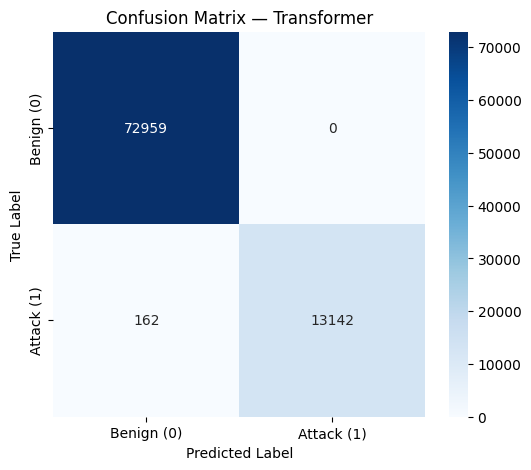

In [28]:
# ===== Confusion Matrix =====
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign (0)", "Attack (1)"],
            yticklabels=["Benign (0)", "Attack (1)"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Transformer")
plt.show()

In [29]:
model.eval()

TransformerTimeSeries(
  (embedding): Linear(in_features=38, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (attn_pool): Linear(in_features=128, out_features=1, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [30]:
import time

model.eval()

# ---- Prediction for sample 1 ----
start_1 = time.perf_counter()

with torch.no_grad():
    out_1 = model(X_1)

end_1 = time.perf_counter()

pred_1 = torch.argmax(out_1, dim=1).item()
time_1 = (end_1 - start_1) * 1000   # to milliseconds

print(f"Sample 1 → Pred: {pred_1} | True: {y_1.item()} | Time: {time_1:.4f} ms")


# ---- Prediction for sample 2 ----
start_2 = time.perf_counter()

with torch.no_grad():
    out_2 = model(X_2)

end_2 = time.perf_counter()

pred_2 = torch.argmax(out_2, dim=1).item()
time_2 = (end_2 - start_2) * 1000   # to milliseconds

print(f"Sample 2 → Pred: {pred_2} | True: {y_2.item()} | Time: {time_2:.4f} ms")


Sample 1 → Pred: 1 | True: 1 | Time: 7.5105 ms
Sample 2 → Pred: 1 | True: 1 | Time: 1.1310 ms


In [37]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print("Frozen:", name)


In [30]:
for xb, yb in train_loader:
    print("Shape:", xb.shape)
    break


Shape: torch.Size([64, 10, 38])
